In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall

In [3]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import yaml
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

In [4]:
# This is where the script will look for the initial data.
ORIGINAL_DATA_PATH = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/'

# --- YOLOv8 Dataset Path ---
# This is where the script will create the formatted dataset.
YOLO_DATASET_PATH = '/kaggle/working/yolo_dataset/'

# --- Model & Training Parameters ---
IMG_SIZE = 640 # YOLOv8 is optimized for larger image sizes like 640
BATCH_SIZE = 16
EPOCHS = 50 # Increase for better results, e.g., to 100
MODEL_CHOICE = 'yolov8n-seg.pt' # Nano model: small, fast, good for starting.
  

In [5]:
def mask_to_yolo_segmentation(mask, img_width, img_height):
    """
    Converts a binary mask to YOLOv8 segmentation polygon format.
    Returns a list of strings, each string being a line in the YOLO label file.
    """
    yolo_annotations = []
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Don't save tiny noise contours
        if cv2.contourArea(contour) < 5:
            continue

        # Normalize contour points
        normalized_contour = contour.astype(np.float32)
        normalized_contour[:, :, 0] /= img_width
        normalized_contour[:, :, 1] /= img_height

        # Flatten the contour points and prefix with class index '0' for 'tumor'
        segment = "0 " + " ".join(map(str, normalized_contour.flatten()))
        yolo_annotations.append(segment)
        
    return yolo_annotations


def prepare_yolo_dataset(df, split, dataset_base_path):
    """
    Processes a dataframe split (train, val, test) and saves images and labels
    in the YOLOv8 required format.
    """
    # Create directories for the split
    img_dir = os.path.join(dataset_base_path, 'images', split)
    lbl_dir = os.path.join(dataset_base_path, 'labels', split)
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split} data"):
        # Define file paths
        image_path = row['image_path']
        mask_path = row['mask_path']
        
        # Load the original image to get its dimensions
        image = cv2.imread(image_path)
        img_height, img_width, _ = image.shape
        
        # Define a new filename to avoid conflicts and include patient info
        base_filename = f"{row['patient_id']}_{os.path.basename(image_path).replace('.tif', '')}"
        
        # Copy image to the new location
        new_image_path = os.path.join(img_dir, base_filename + '.png')
        cv2.imwrite(new_image_path, image) # Save as PNG for consistency

        # Process mask and save as YOLO .txt label
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        yolo_labels = mask_to_yolo_segmentation(mask, img_width, img_height)

        # Only create a label file if a tumor is present in the mask
        if yolo_labels:
            label_path = os.path.join(lbl_dir, base_filename + '.txt')
            with open(label_path, 'w') as f:
                f.write("\n".join(yolo_labels))


def create_yolo_yaml(dataset_path):
    """
    Creates the data.yaml file required for YOLOv8 training.
    """
    yaml_content = {
        'path': os.path.abspath(dataset_path),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'names': {
            0: 'tumor'
        }
    }
    
    yaml_path = os.path.join(dataset_path, 'data.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)
    print(f"Created YOLOv8 dataset YAML at: {yaml_path}")
    return yaml_path


def load_and_split_data(path):
    """
    Loads initial data paths, splits them by patient, and returns dataframes.
    """
    all_patient_folders = sorted([f.path for f in os.scandir(path) if f.is_dir()])
    data = []
    for patient_folder in all_patient_folders:
        patient_id = os.path.basename(patient_folder)
        mask_files = glob(os.path.join(patient_folder, '*_mask.tif'))
        for mask_path in mask_files:
            image_path = mask_path.replace('_mask', '')
            # Check if a tumor is present in the mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if np.sum(mask) > 0: # Only include images with tumors
                if os.path.exists(image_path):
                    data.append({'patient_id': patient_id, 'image_path': image_path, 'mask_path': mask_path})
    
    df = pd.DataFrame(data)
    
    # Split by patient to avoid data leakage
    patient_ids = df['patient_id'].unique()
    train_ids, test_val_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
    val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, random_state=42)

    train_df = df[df['patient_id'].isin(train_ids)]
    val_df = df[df['patient_id'].isin(val_ids)]
    test_df = df[df['patient_id'].isin(test_ids)]
    
    return train_df, val_df, test_df

In [6]:
def visualize_yolo_predictions(model, test_df, num_samples=5):
    """
    Visualizes YOLOv8 model predictions against ground truth for random samples.
    """
    print("\nVisualizing predictions on test samples...")
    # Get a few random samples from the test set
    sample_df = test_df.sample(n=min(num_samples, len(test_df)))
    
    for _, row in sample_df.iterrows():
        original_image_path = row['image_path']
        original_mask_path = row['mask_path']

        # Run prediction
        results = model.predict(source=original_image_path, verbose=0)
        
        # Load original image and ground truth mask
        original_image = cv2.imread(original_image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        true_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Display original MRI
        axes[0].imshow(original_image)
        axes[0].set_title('Original MRI')
        axes[0].axis('off')

        # Display ground truth mask
        axes[1].imshow(true_mask, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')
        
        # Create an empty canvas for the predicted mask
        pred_mask_canvas = np.zeros_like(true_mask, dtype=np.uint8)

        # Check if any masks were detected
        if results[0].masks is not None:
            # Get the first predicted mask and resize it to original dimensions
            pred_mask = results[0].masks.data[0].cpu().numpy()
            pred_mask_resized = cv2.resize(pred_mask, (original_image.shape[1], original_image.shape[0]))
            pred_mask_canvas = (pred_mask_resized > 0.5).astype(np.uint8) * 255

        axes[2].imshow(pred_mask_canvas, cmap='gray')
        axes[2].set_title('YOLOv8 Predicted Mask')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

--- Step 1: Checking for data, loading paths, and splitting... ---
Data split successful: Train(915), Val(234), Test(224)

--- Step 2: Preparing dataset in YOLOv8 format... ---


Processing test data: 100%|██████████| 224/224 [00:01<00:00, 148.88it/s]


Created YOLOv8 dataset YAML at: /kaggle/working/yolo_dataset/data.yaml

--- Step 3: Initializing and training the YOLOv8 model... ---
Ultralytics 8.3.199 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=Fa

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        234        253      0.941      0.815      0.898      0.667      0.936      0.811      0.886      0.587
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to /kaggle/working/runs/segment/yolov8_brain_tumor_segmentation4
Model training complete.

--- Step 4: Evaluating the model on the test set... ---
Ultralytics 8.3.199 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1692.6±293.8 MB/s, size: 86.4 KB)
val: Scanning /kaggle/working/yolo_dataset/labels/test... 224 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 224/224 679.9it/s 0.3s0.0s
val: New cache created: /kaggle/working/yolo_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        224        275      0.868      0.731      0.828      0.566      0.851      0.716      0.804      0.488
Speed: 1.8ms preprocess, 4.9ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/val4

--- Quantitative Test Set Results ---
Segmentation mAP50 (mean Average Precision @ IoU=0.50): 0.8037

--- Step 5: Visualizing predictions on test images... ---

Visualizing predictions on test samples...


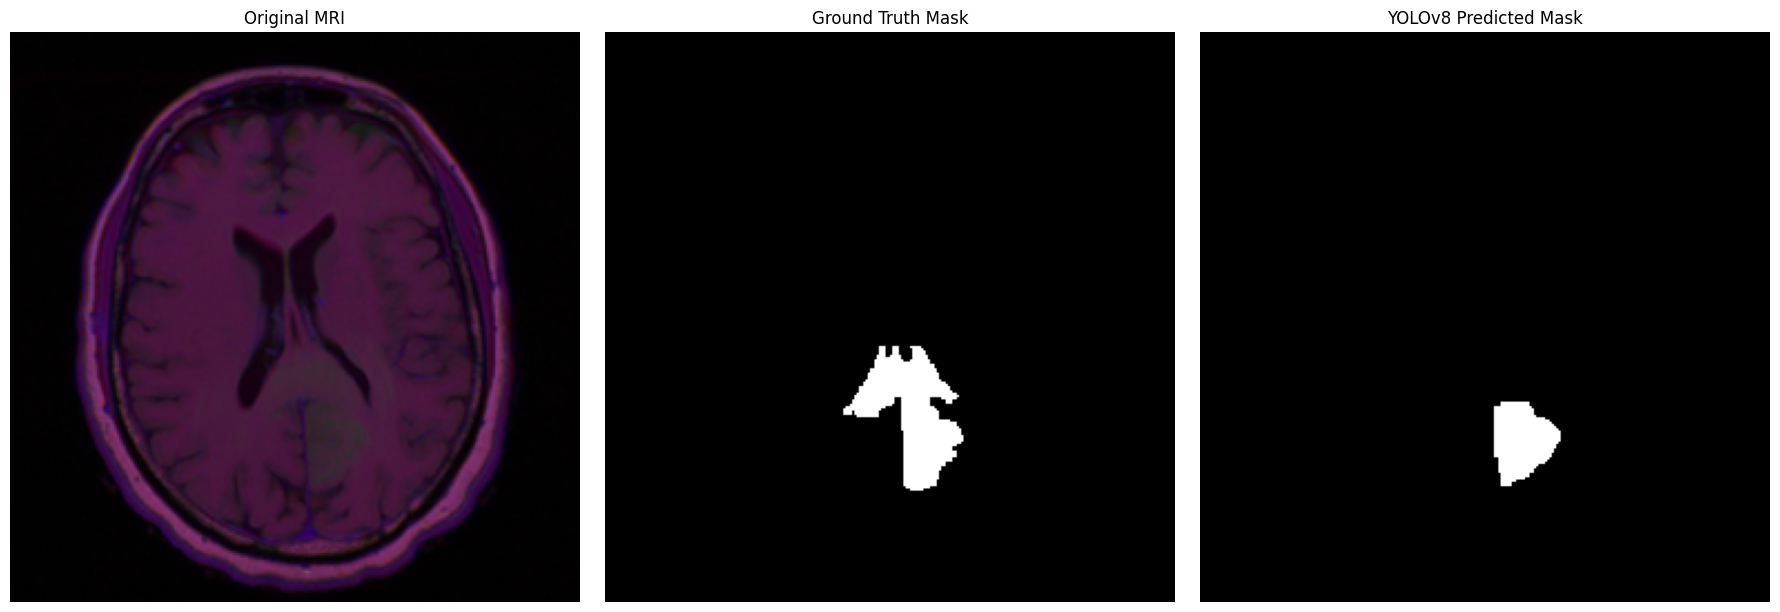

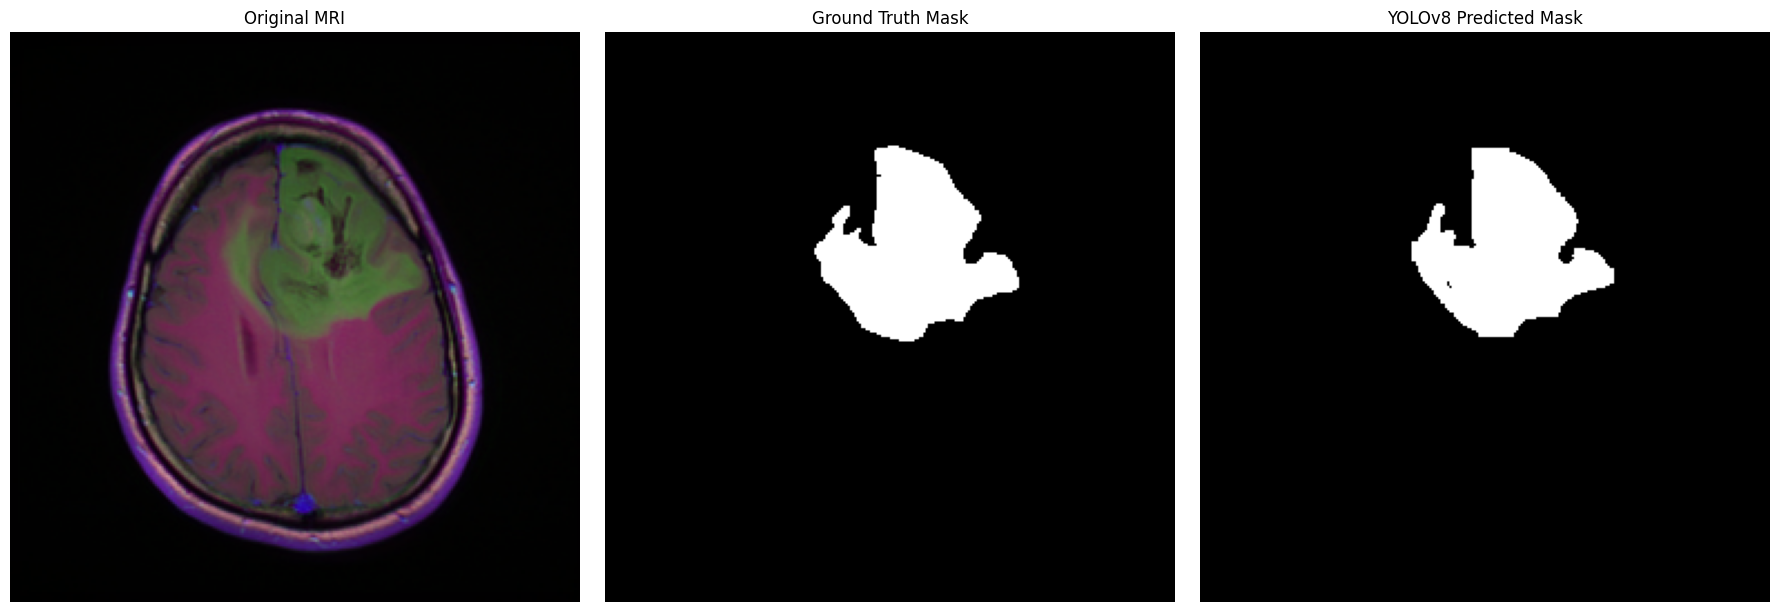

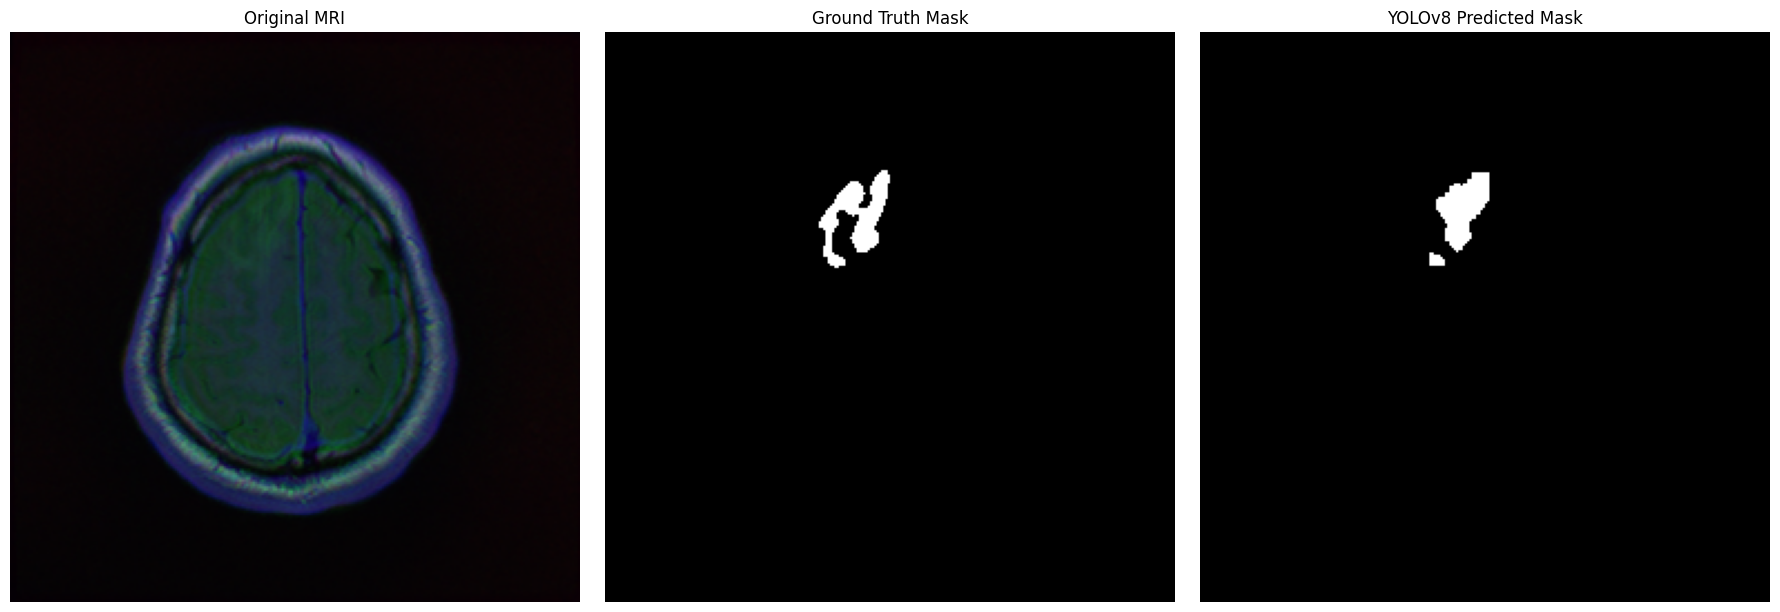

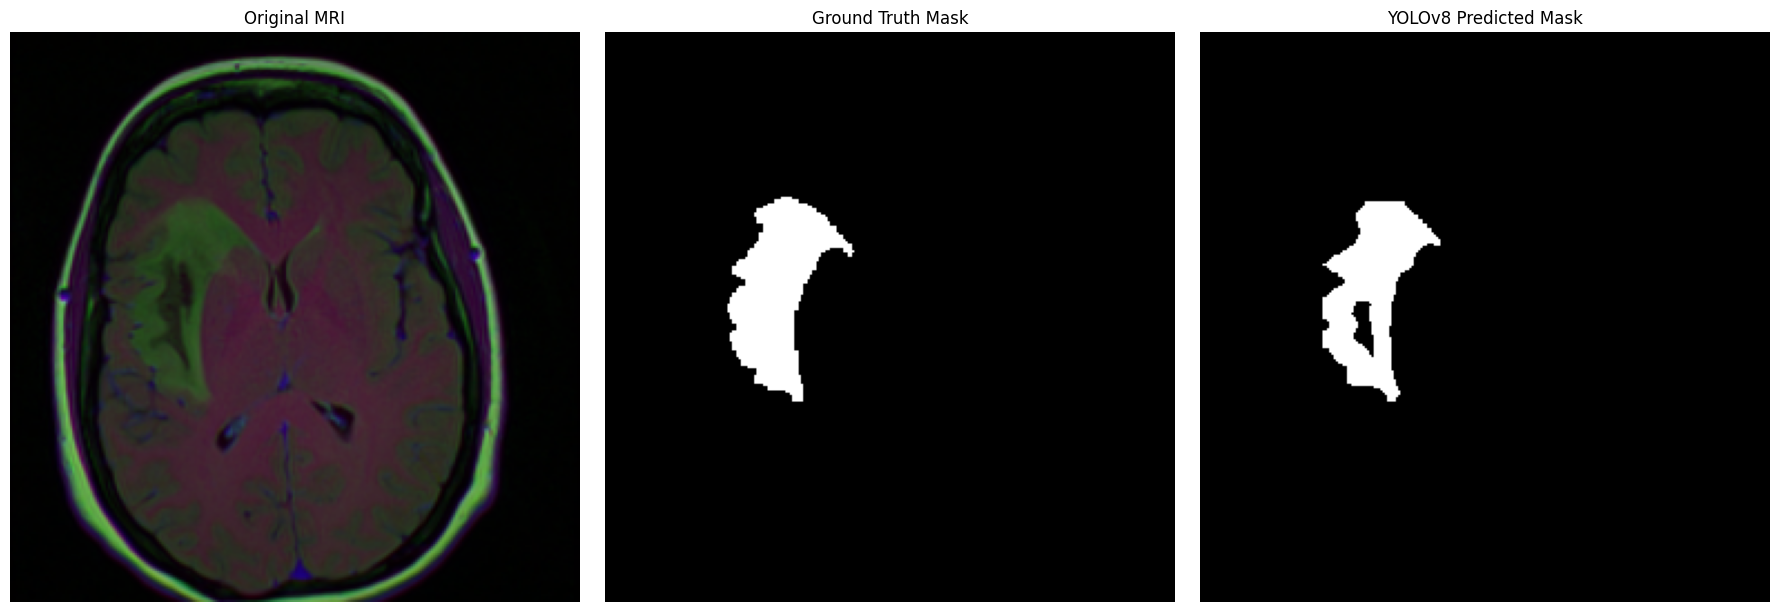

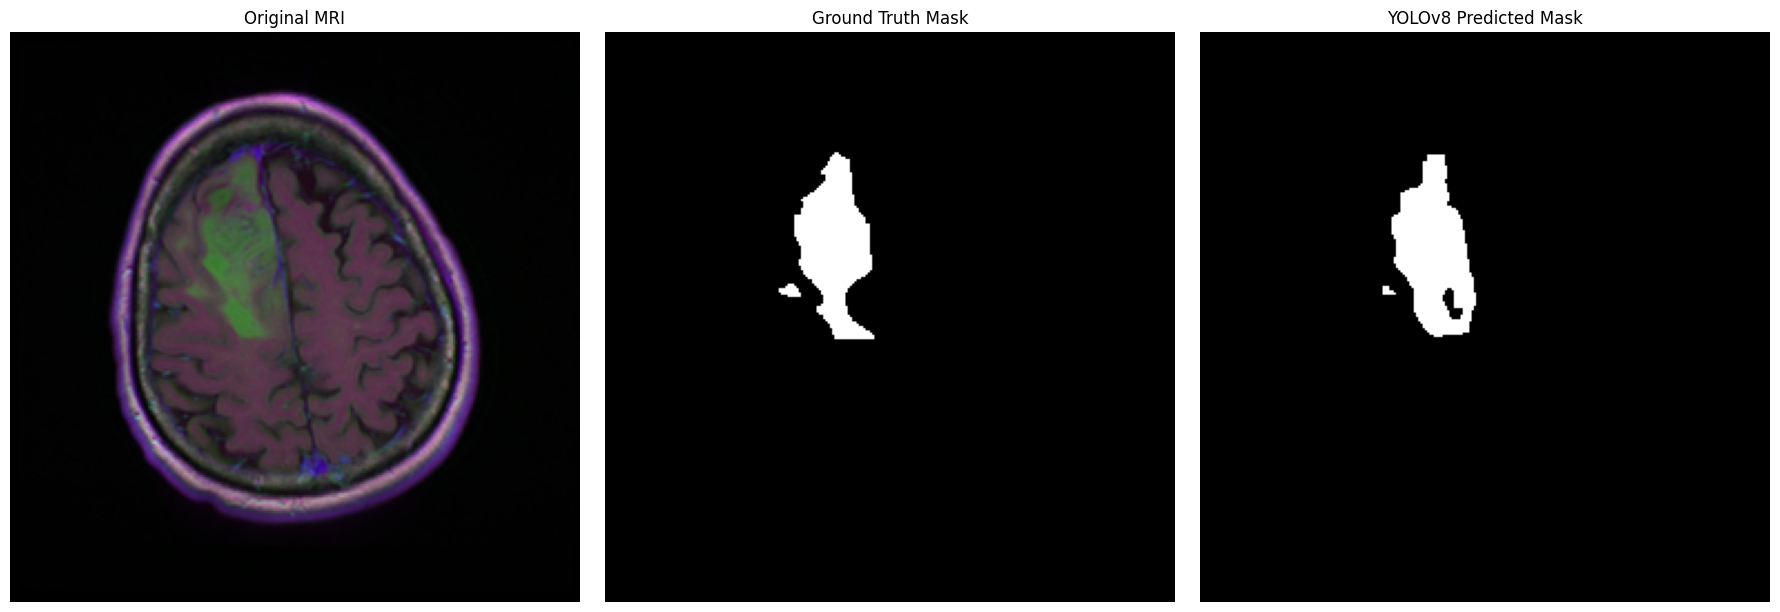


--- Pipeline finished successfully! ---


In [13]:
# %% ========================================
# SECTION 6: MAIN EXECUTION WORKFLOW (with corrected visualization function)
# ========================================

def visualize_yolo_predictions(model, test_df, num_samples=5):
    """
    Visualizes YOLOv8 model predictions against ground truth for random samples.
    """
    print("\nVisualizing predictions on test samples...")
    # Get a few random samples from the test set
    sample_df = test_df.sample(n=min(num_samples, len(test_df)))
    
    for _, row in sample_df.iterrows():
        original_image_path = row['image_path']
        original_mask_path = row['mask_path']

        # Run prediction
        # THIS IS THE CORRECTED LINE: verbose=0 is changed to verbose=False
        results = model.predict(source=original_image_path, verbose=False)
        
        # Load original image and ground truth mask
        original_image = cv2.imread(original_image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        true_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Display original MRI
        axes[0].imshow(original_image)
        axes[0].set_title('Original MRI')
        axes[0].axis('off')

        # Display ground truth mask
        axes[1].imshow(true_mask, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')
        
        # Create an empty canvas for the predicted mask
        pred_mask_canvas = np.zeros_like(true_mask, dtype=np.uint8)

        # Check if any masks were detected
        if results[0].masks is not None and len(results[0].masks.data) > 0:
            # Get the first predicted mask and resize it to original dimensions
            pred_mask = results[0].masks.data[0].cpu().numpy()
            pred_mask_resized = cv2.resize(pred_mask, (original_image.shape[1], original_image.shape[0]))
            pred_mask_canvas = (pred_mask_resized > 0.5).astype(np.uint8) * 255

        axes[2].imshow(pred_mask_canvas, cmap='gray')
        axes[2].set_title('YOLOv8 Predicted Mask')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

def main():
    """
    Main function to run the entire YOLOv8 pipeline.
    """
    # --- Step 1: Check for Data, Load Paths, and Split ---
    print("--- Step 1: Checking for data, loading paths, and splitting... ---")
    if not os.path.exists(ORIGINAL_DATA_PATH):
        print(f"FATAL ERROR: Dataset path not found at '{ORIGINAL_DATA_PATH}'")
        print("Please ensure you have added the 'LGG MRI Segmentation' dataset to your Kaggle Notebook.")
        return
        
    train_df, val_df, test_df = load_and_split_data(ORIGINAL_DATA_PATH)
    print(f"Data split successful: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")
    
    # --- Step 2: Prepare Dataset in YOLOv8 Format ---
    print("\n--- Step 2: Preparing dataset in YOLOv8 format... ---")
    # Clean up previous dataset directory if it exists
    if os.path.exists(YOLO_DATASET_PATH):
        shutil.rmtree(YOLO_DATASET_PATH)
        
    prepare_yolo_dataset(train_df, 'train', YOLO_DATASET_PATH)
    prepare_yolo_dataset(val_df, 'val', YOLO_DATASET_PATH)
    prepare_yolo_dataset(test_df, 'test', YOLO_DATASET_PATH)
    
    # Create the data.yaml file
    yaml_file_path = create_yolo_yaml(YOLO_DATASET_PATH)

    # --- Step 3: Train the YOLOv8 Model ---
    print("\n--- Step 3: Initializing and training the YOLOv8 model... ---")
    
    # Load a pretrained YOLOv8 segmentation model
    model = YOLO(MODEL_CHOICE)
    
    # Train the model
    # Results are automatically saved to a 'runs/segment/train' directory
    model.train(
        data=yaml_file_path,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        name='yolov8_brain_tumor_segmentation' # Name of the output folder
    )
    print("Model training complete.")
    
    # --- Step 4: Evaluate on the Test Set ---
    print("\n--- Step 4: Evaluating the model on the test set... ---")
    # The best model is automatically saved as 'best.pt'
    path_to_best_model = 'runs/segment/yolov8_brain_tumor_segmentation/weights/best.pt'
    
    # Check if the model file exists before loading
    if not os.path.exists(path_to_best_model):
        print(f"Error: Could not find the trained model at '{path_to_best_model}'")
        print("Training may have failed or the output path is different.")
        return

    # Load the best model
    best_model = YOLO(path_to_best_model)
    
    # Run validation on the test set
    metrics = best_model.val(split='test')
    print("\n--- Quantitative Test Set Results ---")
    # The metrics object contains various performance scores.
    # For segmentation, key metrics are under the 'seg' key.
    # Example: Accessing mAP50 for segmentation masks
    map50_seg = metrics.seg.map50
    print(f"Segmentation mAP50 (mean Average Precision @ IoU=0.50): {map50_seg:.4f}")

    # --- Step 5: Visualize Predictions ---
    print("\n--- Step 5: Visualizing predictions on test images... ---")
    visualize_yolo_predictions(best_model, test_df, num_samples=5)

    print("\n--- Pipeline finished successfully! ---")

if __name__ == '__main__':
    # Running in a Kaggle environment, call the main function
    main()